In [1]:
import pandas as pd
import numpy as np
#from numpy.random import seed
#seed(1)

ltrait_new = np.linspace(-4,4, num=100)#np.random.normal(0, 1, size=100)
num_sim_users = ltrait_new.shape[0]
num_sim_items = 3
print('# of sim user:',num_sim_users,'\n# of sim items:',num_sim_items)

# of sim user: 100 
# of sim items: 3


#### Building onto saved dataframe,  following  function appends/extends new records to existing dataset using 'n' bernouli trials.

In [2]:
def add_data(array, trials_per_user):
    array_li= array.tolist()#list of tuples
    dock_list=list()#holds tuples generated from trials
    for u, i, prob in array_li:
        success_failure_arr = np.random.binomial(1, prob, trials_per_user)
        
        for resp in success_failure_arr:
            dock_list.append([u,i, resp])
        
    array_li+=dock_list
    return np.array(array_li)

In [3]:
df_cols = ['user','questions', 'response']

c_probs= pd.read_csv('simulated_data_c_probs.csv')
df_mat = add_data(c_probs.values, trials_per_user=10)
df_sim = pd.DataFrame(df_mat, columns=df_cols)
print('Extended df size:', df_sim.shape)

Extended df size: (3300, 3)


In [4]:
df_sim['response']=df_sim['response'].apply(lambda x: int(np.round(x)))
df_sim.head(3)

,user,questions,response
0,92.0,0.0,1
1,86.0,2.0,1
2,57.0,1.0,1


### Defining a GLM class for two parameterization schemes for 3PL keras models which are as:
**Scheme 1.** `P{i=1,j} = c_j+ (1- c_j)*Sigmoid[a_j*(t_i - b_j)]`
        * P(i,j) = Prob of i-th student, correctly scoring on j-th
          item.
        * t_i= Degree of latent trait of i-th student
        * b_j= difficulty_level of j-th question
        * a_j= discrimination parameter of j-th question
        * c_j= pseudo guessing parameter of j-th question
    
**Scheme 2.** `P{i=1,j} = c_j+ (1- c_j)*Sigmoid[alpha_j + lamda_j*t_i]`
        * P(i,j) = Prob of i-th student, correctly scoring on j-th
          item.
        * t_i= Degree of latent trait of i-th student
        * b_j= difficulty_level of j-th question
        * `lamda_j / a_j`= discrimination parameter of j-th question
        * alpha_j= -lam_j*b_j.
        * c_j = pseudo guessing parameter of j-th question

        



### Now using  dataset  from above, train a keras 1/2/3PL proxy models model using an mlsquare adapter class.

In [5]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(df_sim[df_cols[:-1]], df_sim[df_cols[-1]], test_size=0.05)

x_train_user = to_categorical(xtrain['user'], num_classes=num_sim_users)#contains the one-hot encoded user data
x_train_questions = pd.get_dummies(xtrain['questions']).values#contains the one-hot encoded questions

y_train= ytrain.values
print('shape of simulated x_train_user:', x_train_user.shape,'\nshape of simulated  x_train_questions:', x_train_questions.shape,
      '\nshape of simulated  y_train:',y_train.shape)

Using TensorFlow backend.
/home/kev/Desktop/pyvirtual2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kev/Desktop/pyvirtual2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kev/Desktop/pyvirtual2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kev/Desktop/pyvirtual2/lib/pytho

shape of simulated x_train_user: (3135, 100) 
shape of simulated  x_train_questions: (3135, 3) 
shape of simulated  y_train: (3135,)


#### Loading proxy IRT models & adapter from mlsquare registry

In [6]:
from mlsquare import registry
reg= registry.data
reg

2020-01-02 20:52:37,584	INFO node.py:423 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2020-01-02_20-52-37_10485/logs.
2020-01-02 20:52:37,695	INFO services.py:363 -- Waiting for redis server at 127.0.0.1:52700 to respond...
2020-01-02 20:52:37,834	INFO services.py:363 -- Waiting for redis server at 127.0.0.1:57745 to respond...
2020-01-02 20:52:37,842	INFO services.py:760 -- Starting Redis shard with 20.0 GB max memory.
2020-01-02 20:52:37,888	INFO services.py:1384 -- Starting the Plasma object store with 1.0 GB memory using /dev/shm.


{('embibe',
  'irt'): {'1PL': [<mlsquare.architectures.sklearn.KerasIrt1PLModel at 0x7f60e2413b00>,
   mlsquare.adapters.sklearn.IrtKerasRegressor], '2PL': [<mlsquare.architectures.sklearn.KerasIrt2PLModel at 0x7f60fde72a20>,
   mlsquare.adapters.sklearn.IrtKerasRegressor], '3PL': [<mlsquare.architectures.sklearn.KerasIrt3PLModel at 0x7f60fde72be0>,
   mlsquare.adapters.sklearn.IrtKerasRegressor]},
 ('sklearn',
  'TruncatedSVD'): {'default': [<mlsquare.architectures.sklearn.SVD at 0x7f60fde810f0>,
   mlsquare.adapters.sklearn.SklearnTfTransformer]},
 ('sklearn',
  'LogisticRegression'): {'default': [<mlsquare.architectures.sklearn.LogisticRegression at 0x7f60fde815c0>,
   mlsquare.adapters.sklearn.SklearnKerasClassifier]},
 ('sklearn',
  'LinearRegression'): {'default': [<mlsquare.architectures.sklearn.LinearRegression at 0x7f60fde81780>,
   mlsquare.adapters.sklearn.SklearnKerasRegressor]},
 ('sklearn',
  'Ridge'): {'default': [<mlsquare.architectures.sklearn.Ridge at 0x7f60fde81940>,

* **Instantiating 3PL proxy model class & performing a fit**
    * For scheme 2

In [7]:
proxy, adap = reg[('embibe','irt')]['3PL']
proxy.get_params()

{'l1': 0,
 'l2': 0.01,
 'disc_stddev': 1.0,
 'guess_minval': -3.5,
 'guess_maxval': -2.5,
 'train_guess': True,
 'train_disc': True,
 'guess_act': 'sigmoid',
 'units': 1,
 'activation': 'sigmoid',
 'optimizer': 'sgd',
 'loss': 'binary_crossentropy'}

In [8]:
mod3PL = adap(proxy_model=proxy, primal_model='abc')#adapt object
mod3PL.fit(x_user=x_train_user,x_questions=x_train_questions,
          y_vals=y_train, batch_size=64, epochs=512)


Intitializing fit for scheme 2. . .
Batch_size: 64; epochs: 512;
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.

Training on : 3135 samples for : 512 epochs has completed in : 15.358 seconds.

Use object.plot() to view train/validation loss curves;
Use `object.history` to obtain train/validation loss across all the epochs.
Use `object.coefficients()` to obtain model parameters--difficulty, discrimination & guessing


In [9]:
mod3PL.model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
questions/items (InputLayer)    (None, 3)            0                                            
__________________________________________________________________________________________________
user_id (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
disc_param (Dense)              (None, 1)            3           questions/items[0][0]            
__________________________________________________________________________________________________
latent_trait (Dense)            (None, 1)            100         user_id[0][0]                    
____________________________________________________________________________________________

### Obtaining underlying trained 3pl parameters from doped model

In [10]:
mod3PL.coefficients()

{'difficulty_level': array([[-0.9464835 ],
        [ 0.52767533],
        [ 0.91133845]], dtype=float32), 'disc_param': array([[0.2831977 ],
        [0.12850317],
        [0.43942088]], dtype=float32), 'guessing_param': array([[0.0682517 ],
        [0.03993272],
        [0.03031703]], dtype=float32)}

* **Train Vs. Validation loss curves for simulated dataset**

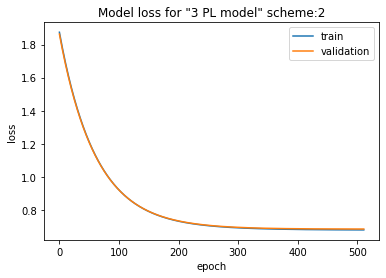

In [11]:
mod3PL.plot()

* **Instantiating 1PL proxy model class & performing a fit**
    * For scheme 2

In [12]:
proxy1PL, adap = reg[('embibe','irt')]['1PL']
print('proxy', proxy1PL)

proxy <mlsquare.architectures.sklearn.KerasIrt1PLModel object at 0x7f60e2413b00>


In [13]:
proxy1PL.get_params()

{'l1': 0,
 'l2': 0,
 'disc_stddev': 0,
 'guess_minval': 0,
 'guess_maxval': 0,
 'train_guess': False,
 'train_disc': False,
 'guess_act': 'linear',
 'units': 1,
 'activation': 'sigmoid',
 'optimizer': 'sgd',
 'loss': 'binary_crossentropy'}

In [14]:
mod1PL = adap(proxy_model=proxy1PL, primal_model='abc')#1PL adapt object
mod1PL.fit(x_user=x_train_user,x_questions=x_train_questions,
          y_vals=y_train, batch_size=64, epochs=512)


Intitializing fit for scheme 2. . .
Batch_size: 64; epochs: 512;

Training on : 3135 samples for : 512 epochs has completed in : 14.169 seconds.

Use object.plot() to view train/validation loss curves;
Use `object.history` to obtain train/validation loss across all the epochs.
Use `object.coefficients()` to obtain model parameters--difficulty, discrimination & guessing


In [15]:
mod1PL.model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
questions/items (InputLayer)    (None, 3)            0                                            
__________________________________________________________________________________________________
user_id (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
disc_param (Dense)              (None, 1)            3           questions/items[0][0]            
__________________________________________________________________________________________________
latent_trait (Dense)            (None, 1)            100         user_id[0][0]                    
____________________________________________________________________________________________

* **Train Vs. Validation loss curves for simulated dataset**

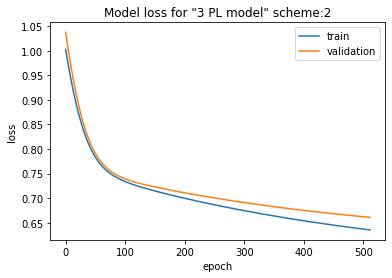

In [16]:
mod1PL.plot()

### Obtaining underlying trained 1pl parameters from doped model

In [17]:
mod1PL.coefficients()

{'difficulty_level': array([[-0.64462066],
        [ 0.04319356],
        [ 0.4156464 ]], dtype=float32), 'disc_param': array([[1.],
        [1.],
        [1.]], dtype=float32), 'guessing_param': array([[0.],
        [0.],
        [0.]], dtype=float32)}

* **Instantiating 2PL proxy model class & performing a fit**
    * For scheme 2

In [20]:
proxy2PL, adap = reg[('embibe','irt')]['2PL']
print('proxy', proxy2PL)

proxy <mlsquare.architectures.sklearn.KerasIrt2PLModel object at 0x7f60fde72a20>


In [21]:
proxy2PL.get_params()

{'l1': 0,
 'l2': 0.01,
 'disc_stddev': 1.0,
 'guess_minval': 0,
 'guess_maxval': 0,
 'train_guess': False,
 'train_disc': True,
 'guess_act': 'linear',
 'units': 1,
 'activation': 'sigmoid',
 'optimizer': 'sgd',
 'loss': 'binary_crossentropy'}

In [22]:
mod2PL = adap(proxy_model=proxy2PL, primal_model='abc')#2PL adapt object
mod2PL.fit(x_user=x_train_user,x_questions=x_train_questions,
          y_vals=y_train, batch_size=64, epochs=512)


Intitializing fit for scheme 2. . .
Batch_size: 64; epochs: 512;

Training on : 3135 samples for : 512 epochs has completed in : 14.505 seconds.

Use object.plot() to view train/validation loss curves;
Use `object.history` to obtain train/validation loss across all the epochs.
Use `object.coefficients()` to obtain model parameters--difficulty, discrimination & guessing


In [23]:
mod2PL.model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
questions/items (InputLayer)    (None, 3)            0                                            
__________________________________________________________________________________________________
user_id (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
disc_param (Dense)              (None, 1)            3           questions/items[0][0]            
__________________________________________________________________________________________________
latent_trait (Dense)            (None, 1)            100         user_id[0][0]                    
____________________________________________________________________________________________

* **Train Vs. Validation loss curves for simulated dataset**

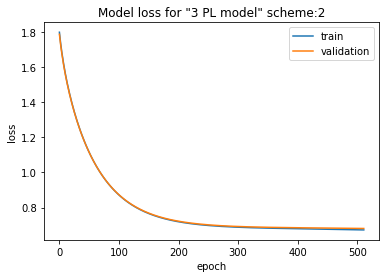

In [24]:
mod2PL.plot()

### Obtaining underlying trained 2pl parameters from doped model

In [25]:
mod2PL.coefficients()

{'difficulty_level': array([[-0.4051965 ],
        [ 0.05209438],
        [ 0.4704628 ]], dtype=float32), 'disc_param': array([[0.9952554 ],
        [1.4493258 ],
        [0.20508881]], dtype=float32), 'guessing_param': array([[0.],
        [0.],
        [0.]], dtype=float32)}